### FEATURES TO BE ADDED
1. Monthly time horizontal
2. Tangency Portfolio with and without short-selling
3. CAL with and without short-selling

In [1]:
%matplotlib inline
import numpy as np
from numpy.linalg import solve, inv
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
# Abupy for data extraction of HK stock market
import abupy

solvers.options['show_progress'] = False

### 1. Data Extraction

In [2]:
# Simple return in %
def get_return(pre_close, log_ret = False):
    new = pre_close[1:]
    old = pre_close[:-1]
    if log_ret == False:
        return_vec = (new-old)/old 
        return_vec = 100 * return_vec
    else:
        return_vec = np.log(new / old)
        return_vec = 100 * return_vec
    return  return_vec

# Row vectors are time-series ;Column vectors are cross-sectional
# Coerce NaN to 0
# Get daily return
def get_return_matrix(choice_symbols, n_year):
    kl = abupy.ABuSymbolPd.make_kl_df(choice_symbols, n_folds=2)
    return_mat = []
    for symbol in kl:
        pre_close = np.array(kl[symbol].pre_close, dtype = np.float64)
        return_vec = get_return(pre_close)
        return_mat.append(return_vec)
    return_mat = np.matrix(return_mat, dtype = np.float64)
    np.nan_to_num(return_mat, copy = False)
    return return_mat

In [3]:
# 7 Stocks with 2 years historical returns
choice_symbols = ['hk03333', 'hk00700', 'hk02333', 'hk01359', 'hk00656', 'hk03888', 'hk02318']
kl = abupy.ABuSymbolPd.make_kl_df(choice_symbols, n_folds=2)
return_mat = get_return_matrix(choice_symbols, 2)

Box(children=(Text(value='pid=966 begin work'), FloatProgress(value=0.0)))

Box(children=(Text(value='pid=966 begin work'), FloatProgress(value=0.0)))

### 2. Sample Portfolios

In [4]:
# random genrate weight
# Reference: https://blog.quantopian.com/markowitz-portfolio-optimization-2/
def rand_weight(n):
    k = np.random.rand(n)
    return k / sum(k)

# random generate portfolio
def rand_portfolio(returns):
    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weight(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return rand_portfolio(returns)
    return mu, sigma

In [5]:
# Simulate portfolios with random weights
n_portfolios = 8000
means, stds = np.column_stack([
    rand_portfolio(return_mat) for _ in range(n_portfolios)
])

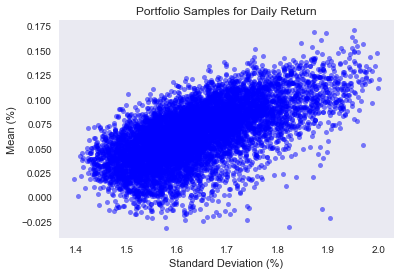

In [6]:
plt.grid(False)
plt.plot(stds, means, 'bo', markersize = 5, alpha = 0.5)
plt.xlabel('Standard Deviation (%)')
plt.ylabel('Mean (%)')
plt.title('Portfolio Samples for Daily Return');

* A number of random weights on 4 assets are generated. Each point represents an instance.

### 2. EFFICIENT FRONTIER

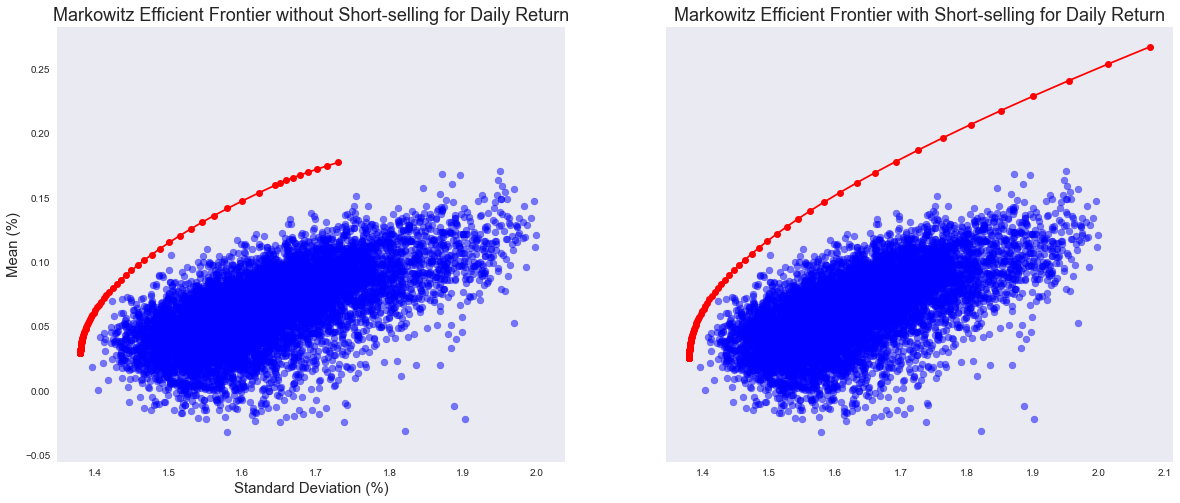

In [62]:
# Reference: https://github.com/markharley/Markowitz/blob/master/markowitz.py
def efficient_frontier(returns, short_sell = False):
    n = len(returns)
    returns = np.asmatrix(returns)

    N = 200
    qs = [10**(-5.0 * t/N + 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))

    # np.mean computes vector of means along
    # as mean of each row
    pbar = opt.matrix(np.mean(returns, axis=1))

    # Create constraint matrices
    # -- documentation at http://cvxopt.org/userguide/coneprog.html#quadratic-programming
    if short_sell == True:
        G = -opt.matrix(0.0, (n, n)) # negative nxn id
    else:
        G = -opt.matrix(np.eye(n))
    h = opt.matrix(0.0, (n, 1)) # n x 1 zero vector
    A = opt.matrix(1.0, (1, n)) # 1 x n 1-vector
    b = opt.matrix(1.0) # [1.0]

    ## Calculate efficient frontier weights using quadratic programming
    # q is a measure of risk tolerance
    portfolios = [solvers.qp(S, -q*pbar, G, h, A, b)['x'] for q in qs]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights_woss, returns_woss, risks_woss = efficient_frontier(return_mat, short_sell = False)
weights_wss, returns_wss, risks_wss = efficient_frontier(return_mat, short_sell = True)

f, (ax1, ax2) = plt.subplots(1, 2 ,sharey=True, figsize = (20, 8))
# Plot for efficient frontier without short-selling
ax1.grid(False)
ax1.scatter(stds, means, c = 'b', alpha = 0.5)
ax1.plot(risks_woss, returns_woss, 'r-o')
ax1.set_title('Markowitz Efficient Frontier without Short-selling for Daily Return', fontdict={'fontsize': 18})
ax1.set_xlabel('Standard Deviation (%)', fontdict = {'fontsize': 15})
ax1.set_ylabel('Mean (%)', fontdict = {'fontsize': 15})

# Plot for efficient frontier with short-selling
ax2.grid(False)
ax2.scatter(stds, means, c = 'b', alpha = 0.5)
ax2.plot(risks_wss, returns_wss, 'r-o')
ax2.set_title('Markowitz Efficient Frontier with Short-selling for Daily Return', fontdict={'fontsize': 18})
ax1.set_xlabel('Standard Deviation (%)', fontdict = {'fontsize': 15})
ax1.set_ylabel('Mean (%)', fontdict = {'fontsize': 15});

* Efficient frontier is marked as red and it shows up in upper position
* With allowing short-selling, efficient frontier extend far rightwards, implying the yield is leverage with greater risks
* To be specific, the frontier with short-selling expands the limit of risk from approximately 1.7% to approximately 2.1%
* As the number of assets increase, it's more difficult to find out the efficient frontier by brute-force simulation of random weight

### 3. TANGENCY PORTFOLIO

In [39]:
# Note inverse operation is numerically ill-conditioned
def tangency_portfolio(returns, risk_free):
    # Get covariance and mean 
    S = np.matrix(np.cov(returns), dtype = np.float64)
    S_inv = inv(S)
    pbar = np.mean(returns, axis=1)
    dim = pbar.shape
    rf_vec = np.resize([risk_free], dim)
    # Get normalized weight
    unnorm_w = S_inv * (pbar - rf_vec)
    norm = np.sum(unnorm_w)
    norm_w = unnorm_w / norm
    # Get return and risk
    returns = np.asscalar(pbar.T * norm_w)
    risks = np.asscalar(np.sqrt(norm_w.T * S * norm_w))
    return returns, risks

In [60]:
tangency_portfolio(return_mat)

(0.09912329039415002, 1.4583380584063748)

In [24]:
S = np.matrix(np.cov(return_mat), dtype = np.float64)
S_inv = inv(S)
pbar = np.mean(return_mat, axis=1)
dim = pbar.shape
rf_vec = np.resize([0.05], dim)
# Get normalized weight
unnorm_w = S_inv * (pbar - rf_vec)
norm = np.sum(unnorm_w)
norm_w = unnorm_w / norm

### 4. CAPITAL ALLOCATION LINE (CAL)